# Inference: Hamiltonian MCMC

This example shows you how to perform Bayesian inference on a Normal distribution and a time-series problem, using [Hamiltonian Monte Carlo](http://pints.readthedocs.io/en/latest/mcmc_samplers/hamiltonian_mcmc.html).


First, we create a simple normal distribution

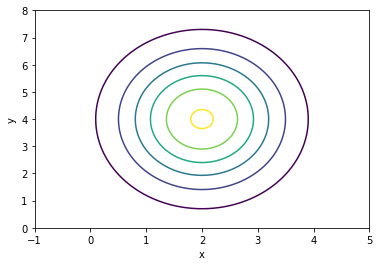

In [1]:
import os
os.chdir("../")
import pints
import pints.toy
import numpy as np
import matplotlib.pyplot as plt

# Create log pdf
log_pdf = pints.toy.NormalLogPDF([2, 4], [[1, 0], [0, 3]])

# Contour plot of pdf
levels = np.linspace(-3,12,20)
num_points = 100
x = np.linspace(-1, 5, num_points)
y = np.linspace(-0, 8, num_points)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z = np.exp([[log_pdf([i, j]) for i in x] for j in y])
plt.contour(X, Y, Z)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Now we set up and run a sampling routine using Hamiltonian MCMC

In [2]:
# Choose starting points for 3 mcmc chains
xs = [
    [2, 1],
    [3, 3],
    [5, 4],
]

# Set a standard deviation, to give the method a sense of scale
#sigma = [1, 1]

# Create mcmc routine
mcmc = pints.MCMCSampling(log_pdf, 3, xs, method=pints.HamiltonianMCMC)

# Add stopping criterion
mcmc.set_max_iterations(1000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(100)

# # Update step sizes used by individual samplers
for sampler in mcmc.samplers():
    sampler.set_leapfrog_step_size(0.5)

# Run!
print('Running...')
full_chains = mcmc.run()
print('Done!')

Running...
Using Hamiltonian MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     63     0.333     0.333     0.333      0:00.0
2     123    0.5       0.5       0.5        0:00.0
3     183    0.6       0.6       0.6        0:00.0
100   6003   0.98      0.98      0.98       0:00.8
200   12003  0.990099  0.990099  0.990099   0:01.6
300   18003  0.993     0.993     0.993      0:02.3
400   24003  0.995     0.995     0.995      0:03.1
500   30003  0.996     0.996     0.996      0:03.9
600   36003  0.997     0.997     0.997      0:04.7
700   42003  0.997151  0.997151  0.997151   0:05.4
800   48003  0.998     0.998     0.998      0:06.2
900   54003  0.998     0.998     0.998      0:07.0
1000  59943  0.998002  0.998002  0.998002   0:07.8
Halting: Maximum number of iterations (1000) reached.
Done!


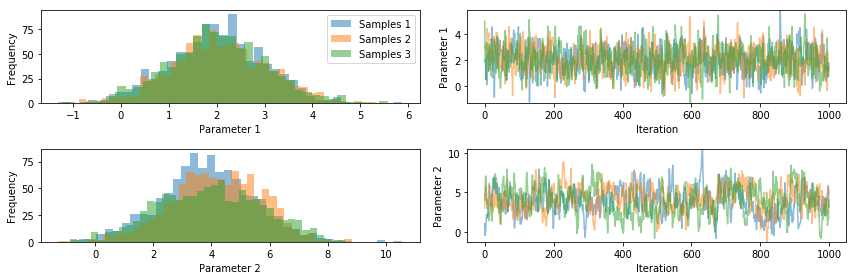

In [3]:
# Show traces and histograms
import pints.plot
pints.plot.trace(full_chains)
plt.show()

R-hat:
[0.99956895432481918, 1.0144332615133789]
0.00624509029494
0.030038765552
0.0250127755373


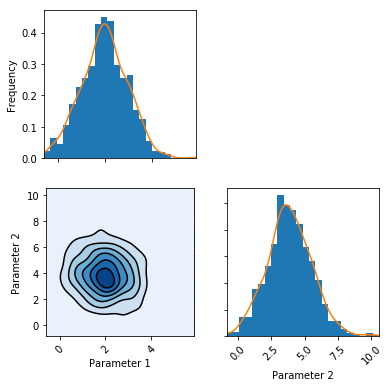

In [4]:
# Discard warm up
chains = full_chains[:, 200:]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains))

# Check Kullback-Leibler divergence of chains
print(log_pdf.kl_divergence(chains[0]))
print(log_pdf.kl_divergence(chains[1]))
print(log_pdf.kl_divergence(chains[2]))

# Look at distribution in chain 0
pints.plot.pairwise(chains[0], kde=True)
plt.show()

It seems Hamiltonian MCMC does very well at this problem!

## Hamiltonian MCMC on a time-series problem

We now try the same method on a time-series problem

First, we try it in 1d, using a wrapper around the LogisticModel to make it one-dimensional.

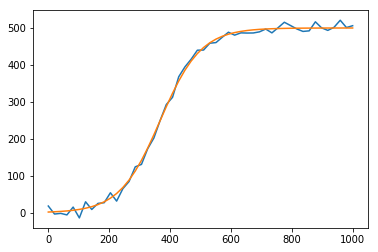

In [5]:
import pints.toy as toy

# Create a wrapper around the logistic model, turning it into a 1d model
class Model(pints.ForwardModel):
    def __init__(self):
        self.model = toy.LogisticModel()
    def simulate(self, x, times):
        return self.model.simulate([x[0], 500], times)
    def simulateS1(self, x, times):
        values, gradient = self.model.simulateS1([x[0], 500], times)
        gradient = gradient[:, 0]
        return values, gradient
    def n_parameters(self):
        return 1

# Load a forward model
model = Model()
    
# Create some toy data
real_parameters = np.array([0.015])
times = np.linspace(0, 1000, 50)
org_values = model.simulate(real_parameters, times)

# Add noise
np.random.seed(1)
noise = 10
values = org_values + np.random.normal(0, noise, org_values.shape)

plt.figure()
plt.plot(times, values)
plt.plot(times, org_values)
plt.show()

We can use optimisation to find the parameter value that maximises the loglikelihood, and note that it's become slightly biased due to noise.

In [6]:
# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function
log_likelihood = pints.KnownNoiseLogLikelihood(problem, noise)

# Find the best parameters with XNES
best_parameters, fx = pints.optimise(log_likelihood, real_parameters, method=pints.XNES)
print(best_parameters[0])

Maximising LogPDF
using Exponential Natural Evolution Strategy (xNES)
Running in sequential mode.
Population size: 4
Iter. Eval. Best      Time m:s
0     4     -374.2353   0:00.0
1     8     -374.2353   0:00.0
2     12    -335.1027   0:00.0
3     16    -190.6176   0:00.0
20    84    -184.5913   0:00.0
40    164   -184.5911   0:00.0
60    244   -184.5911   0:00.0
80    324   -184.5911   0:00.1
100   404   -184.5911   0:00.1
120   484   -184.5911   0:00.1
140   564   -184.5911   0:00.1
160   644   -184.5911   0:00.1
180   724   -184.5911   0:00.1
200   804   -184.5911   0:00.1
220   884   -184.5911   0:00.1
240   964   -184.5911   0:00.1
249   996   -184.5911   0:00.1
Halting: No significant change for 200 iterations.
0.0149936086003


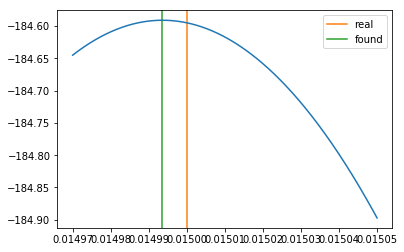

In [7]:
# Show the likelihood near the true parameters
plt.figure()
x = np.linspace(0.01497, 0.01505, 500)
y = [log_likelihood([i]) for i in x]
plt.axvline(real_parameters[0], color='tab:orange', label='real')
plt.axvline(best_parameters[0], color='tab:green', label='found')
plt.legend()
plt.plot(x, y)
plt.show()

Because the LogisticModel (and our wrapper) support the `evaluatS1()` method, we can also evaluate the gradient of the loglikelihood at different points:

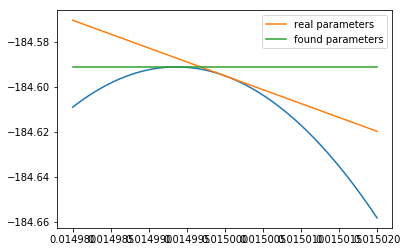

In [8]:
# Show derivatives at two points
y1, dy1 = log_likelihood.evaluateS1(real_parameters)
y2, dy2 = log_likelihood.evaluateS1(best_parameters)

# Show the likelihood near the true parameters
x = np.linspace(0.01498, 0.01502, 500)
y = [log_likelihood([i]) for i in x]
z1 = y1 + (x - real_parameters[0]) * dy1
z2 = y2 + (x - best_parameters[0]) * dy2

plt.figure()
plt.plot(x, y)
plt.plot(x, z1, label='real parameters')
plt.plot(x, z2, label='found parameters')
plt.legend()
plt.show()

Satisfied that this works, we now run a HamiltonianMCMC routine (which uses the derivative information)

In [9]:
# Choose starting points for mcmc chains
xs = [
    real_parameters * 1.01,
    real_parameters * 0.9,
    real_parameters * 1.15,
]

# Choose a covariance matrix for the proposal step
#sigma0 = (best_parameters - real_parameters) * 0.1
sigma0 = np.abs(real_parameters)

# Create mcmc routine
mcmc = pints.MCMCSampling(log_likelihood, len(xs), xs, method=pints.HamiltonianMCMC)

# Add stopping criterion
mcmc.set_max_iterations(1000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(100)

# Set small step size
# for sampler in mcmc.samplers():
#     sampler.set_leapfrog_step_size(3e-5)   # This is very sensitive!

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

Running...
Using Hamiltonian MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     63     0.333     0.333     0.333      0:00.0
2     123    0.5       0.5       0.5        0:00.0
3     183    0.6       0.6       0.6        0:00.0
100   6003   0.98      0.98      0.98       0:01.2
200   12003  0.990099  0.985     0.990099   0:02.4
300   18003  0.993     0.986755  0.993      0:03.6
400   24003  0.995     0.99      0.995      0:04.8
500   30003  0.996     0.992     0.996      0:06.0
600   36003  0.993     0.993     0.997      0:07.2
700   42003  0.993     0.994302  0.997151   0:08.4
800   48003  0.994     0.995     0.996      0:09.6
900   54003  0.993     0.996     0.997      0:10.8
1000  59943  0.994006  0.996004  0.997003   0:12.0
Halting: Maximum number of iterations (1000) reached.
Done!


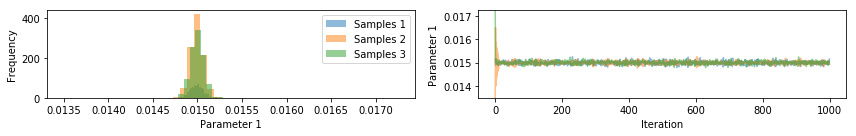

In [10]:
# Show trace and histogram
pints.plot.trace(chains)
plt.show()

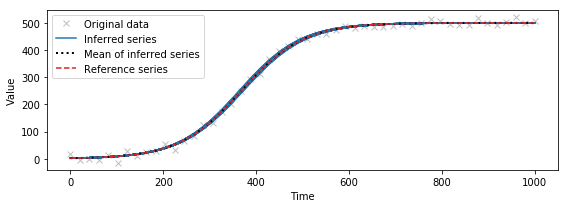

In [11]:
# Show predicted time series for the first chain
pints.plot.series(chains[0, 200:], problem, real_parameters)
plt.show()

## 2d Time series

Finally, we try Hamiltonian MCMC on a 2d logistic model problem:

In [18]:
from __future__ import print_function
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

# Load a forward model
model = toy.LogisticModel()

# Create some toy data
real_parameters = np.array([0.015, 500])
org_values = model.simulate(real_parameters, times)

# Add noise
np.random.seed(1)
noise = 10
values = org_values + np.random.normal(0, noise, org_values.shape)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function
log_likelihood = pints.KnownNoiseLogLikelihood(problem, noise)

# Create a uniform prior over the parameters
log_prior = pints.UniformLogPrior(
    [0.01, 400],
    [0.02, 600]
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Choose starting points for 3 mcmc chains
xs = [
    real_parameters * 1.01,
    real_parameters * 0.9,
    real_parameters * 1.1,
]

# Create mcmc routine
mcmc = pints.MCMCSampling(log_posterior, len(xs), xs, method=pints.HamiltonianMCMC)

# Add stopping criterion
mcmc.set_max_iterations(1000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(100)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

Running...
Using Hamiltonian MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     63     0.333     0.333     0.333      0:00.0
2     123    0.5       0.5       0.5        0:00.0
3     183    0.6       0.6       0.6        0:00.1
100   6003   0.98      0.971     0.98       0:01.4
200   12003  0.990099  0.985     0.980198   0:02.8
300   18003  0.993     0.99      0.986755   0:04.1
400   24003  0.993     0.99      0.99       0:05.5
500   30003  0.994     0.992     0.992      0:06.9
600   36003  0.995     0.993     0.993      0:08.2
700   42003  0.996     0.994302  0.994302   0:09.6
800   48003  0.995     0.995     0.995      0:11.0
900   54003  0.996     0.994     0.996      0:12.3
1000  59943  0.996004  0.995005  0.996004   0:13.6
Halting: Maximum number of iterations (1000) reached.
Done!


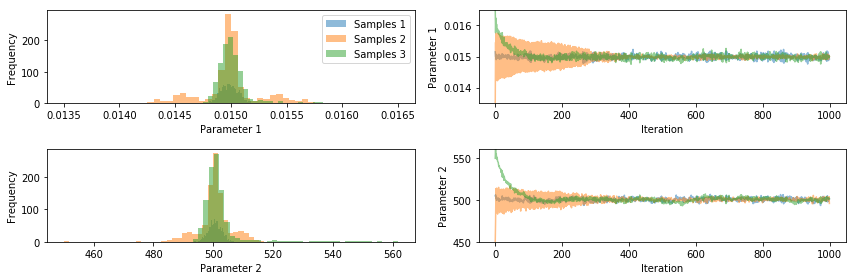

In [19]:
# Show traces and histograms
pints.plot.trace(chains)
plt.show()

Chains have converged!

In [17]:
# Discard warm up
chains = chains[:, 200:]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains))

R-hat:
[0.99947031132463748, 0.99979989669817704]
